In [1]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns

#Text Preprocessing
import re
import string
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

#Model building
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/youtube-statistics/videos-stats.csv
/kaggle/input/youtube-statistics/comments.csv


In [2]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Loading Data

In [3]:
df = pd.read_csv('/kaggle/input/youtube-statistics/comments.csv')
df.head()

,Unnamed: 0,Video ID,Comment,Likes,Sentiment
0,0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95.0,1.0
1,1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19.0,0.0
2,2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161.0,2.0
3,3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8.0,0.0
4,4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34.0,2.0


In [4]:
df.shape

(18409, 5)

# Data Cleaning and EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18409 entries, 0 to 18408
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  18409 non-null  int64  
 1   Video ID    18409 non-null  object 
 2   Comment     18408 non-null  object 
 3   Likes       18409 non-null  float64
 4   Sentiment   18409 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 719.2+ KB


In [6]:
df.columns

Index(['Unnamed: 0', 'Video ID', 'Comment', 'Likes', 'Sentiment'], dtype='object')

In [7]:
df.drop(['Unnamed: 0', 'Video ID', 'Likes'], axis=1, inplace=True)

In [8]:
df.isnull().sum()

Comment      1
Sentiment    0
dtype: int64

In [9]:
df.dropna(subset='Comment', inplace=True)

In [10]:
df.duplicated().sum()

414

In [11]:
df.drop_duplicates(keep='first', inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17994 entries, 0 to 18408
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Comment    17994 non-null  object 
 1   Sentiment  17994 non-null  float64
dtypes: float64(1), object(1)
memory usage: 421.7+ KB


In [13]:
df['Sentiment'].value_counts()

Sentiment
2.0    11141
1.0     4532
0.0     2321
Name: count, dtype: int64

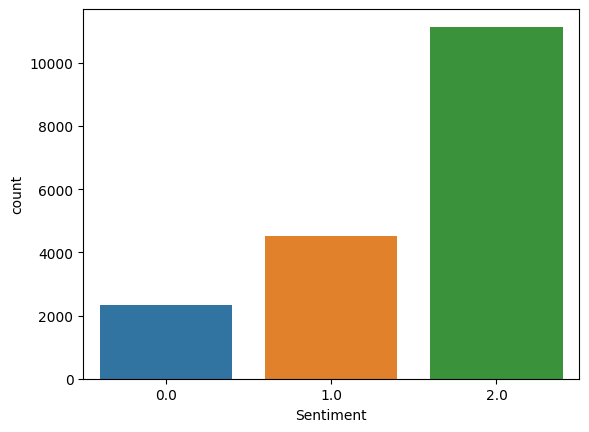

In [14]:
sns.countplot(x=df['Sentiment'])
plt.show()

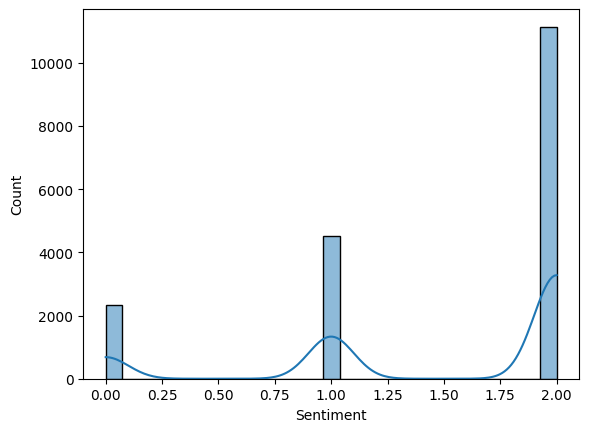

In [15]:
sns.histplot(df['Sentiment'], kde=True)
plt.show()

# Text Preprocessing

In [16]:
def clean_text(text):
    stop = stopwords.words('english')
    punc = list(punctuation)
    bad_tokens = stop + punc
    lemma = WordNetLemmatizer()
    tokens = word_tokenize(text)
    word_tokens = [t for t in tokens if t.isalpha()]
    clean_token = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in bad_tokens]
    return ' '.join(clean_token)

In [17]:
df['text'] = df['Comment'].apply(clean_text)

# Word Cloud

In [18]:
all_words = ' '.join(word for word in df['text'])

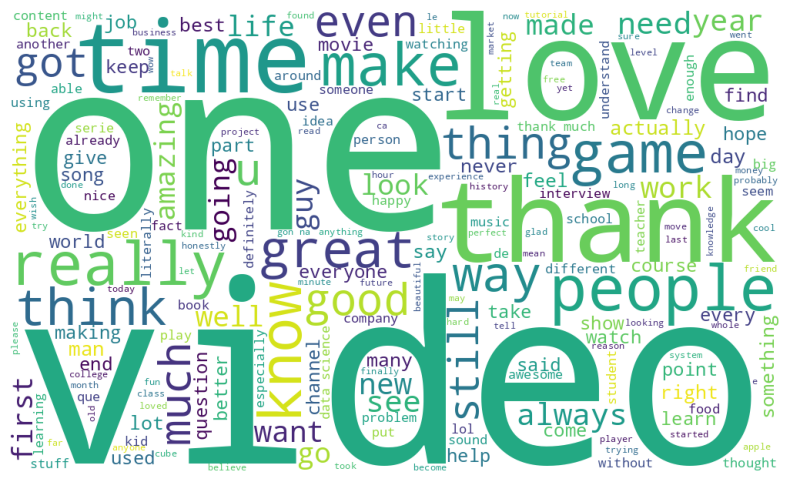

In [19]:
wordcloud = WordCloud(
    width = 1000,
    height = 600,
    background_color = 'white').generate(all_words)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Model Building

In [20]:
X = df['text']
y = df['Sentiment']

In [21]:
vec = TfidfVectorizer()
X = vec.fit_transform(X).toarray()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Naive Bayes**

In [27]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [28]:
y_pred = model.predict(X_test)

In [29]:
def eval(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    t1 = ConfusionMatrixDisplay(cm)
    print('Classification Report for Naive Bayes: \n')
    print(classification_report(y_test, y_pred))
    t1.plot()

Classification Report for Naive Bayes: 

              precision    recall  f1-score   support

         0.0       1.00      0.01      0.01       479
         1.0       0.73      0.21      0.32       954
         2.0       0.63      0.97      0.76      2166

    accuracy                           0.64      3599
   macro avg       0.79      0.39      0.37      3599
weighted avg       0.71      0.64      0.55      3599



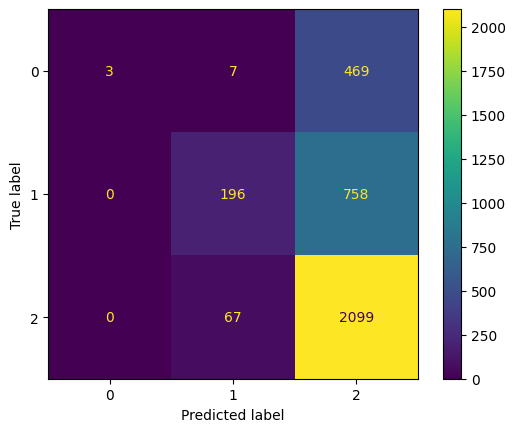

In [30]:
eval('Classification Report', y_test, y_pred)

**Random Forest**

In [31]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [32]:
y_pred = model.predict(X_test)

In [33]:
def eval(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    t1 = ConfusionMatrixDisplay(cm)
    print('Classification Report for Random Forest: \n')
    print(classification_report(y_test, y_pred))
    t1.plot()

Classification Report for Random Forest: 

              precision    recall  f1-score   support

         0.0       0.73      0.08      0.14       479
         1.0       0.63      0.52      0.57       954
         2.0       0.72      0.92      0.81      2166

    accuracy                           0.70      3599
   macro avg       0.69      0.51      0.51      3599
weighted avg       0.70      0.70      0.66      3599



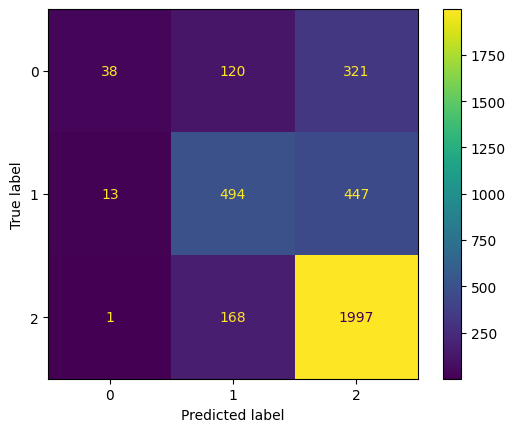

In [34]:
eval('Classification Report', y_test, y_pred)

**Support Vector Classifier**

In [35]:
model = SVC()
model.fit(X_train, y_train)

SVC()

In [36]:
y_pred = model.predict(X_test)

In [37]:
def eval(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    t1 = ConfusionMatrixDisplay(cm)
    print('Classification Report for SVC: \n')
    print(classification_report(y_test, y_pred))
    t1.plot()

Classification Report for SVC: 

              precision    recall  f1-score   support

         0.0       0.74      0.15      0.25       479
         1.0       0.62      0.57      0.60       954
         2.0       0.76      0.92      0.83      2166

    accuracy                           0.72      3599
   macro avg       0.71      0.55      0.56      3599
weighted avg       0.72      0.72      0.69      3599



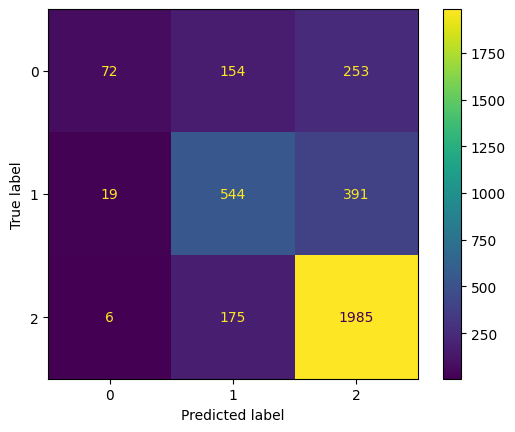

In [38]:
eval('Classification Report', y_test, y_pred)